In [1]:
!pip install tensorflow
!pip install numpy
!pip install pandas
!pip install nltk


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 8.1 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.2.1
    Uninstalling keras-3.2.1:
      Successfully uninstalled keras-3.2.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import string, os
import nltk
import re
import random
import io
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding, Dropout, LSTM, Dense, Bidirectional 
from tensorflow.keras.callbacks import EarlyStopping

2024-04-28 18:38:21.098105: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-28 18:38:21.098259: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-28 18:38:21.221533: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
data = pd.read_csv("/kaggle/input/dataset/final_final_data.csv")

In [4]:
data

,Track Name,Album Name,Lyrics,No_of_Characters,No_of_Words
0,Beaches by Lana Del Rey,Lust for Life by Lana Del Rey,"i don't belong in the world, that's what it is...",1281,302
1,Liner Notes by Taylor Swift,by Taylor Swift,"i was born in reading, pennsylvania on decembe...",3798,817
2,by Lana Del Rey,Honeymoon by Lana Del Rey,there's only hours in a day and half as many ...,999,219
3,by Taylor Swift,Red by Taylor Swift,it feels like a perfect night to dress up like...,2187,464
4,"""Heroes"" by David Bowie","""Heroes"" by David Bowie","i, i will be king and you, you will be queen ...",1297,305
...,...,...,...,...,...
786,"Old days, glory days",NaN,lyrics for this song have yet to be released p...,94,18
787,Olivia by One Direction,Made in the A.M. by One Direction,fortythree and then and then you've gotta play...,1656,417
788,Omaha Mall,NaN,kenny hamilton tell them how it is okay we bet...,2041,439
789,Orange Colored Sky Live,A Very Gaga Holiday,solet's do orange colored sky yeah i used to s...,1053,213


In [5]:
data.isna().sum()

Track Name           0
Album Name          29
Lyrics               0
No_of_Characters     0
No_of_Words          0
dtype: int64

In [6]:
data['Lyrics'] = data['Lyrics'].astype(str)

In [7]:
non_alphabetic_pattern = re.compile(r'[^a-zA-Z\s]')

In [8]:
# Replace non-alphabetic characters with blank spaces in the 'Lyrics' column
data['Lyrics'] = data['Lyrics'].str.replace(non_alphabetic_pattern, ' ', regex=True)

# Example: Printing the updated DataFrame
print(data['Lyrics'])

0      i don t belong in the world  that s what it is...
1      i was born in reading  pennsylvania on decembe...
2      there s only  hours in a day and half as many ...
3      it feels like a perfect night to dress up like...
4      i  i will be king and you  you will be queen  ...
                             ...                        
786    lyrics for this song have yet to be released p...
787    fortythree and then and then you ve gotta play...
788    kenny hamilton tell them how it is okay we bet...
789    solet s do orange colored sky yeah i used to s...
790    i kw that you all have been feeling a tremendo...
Name: Lyrics, Length: 791, dtype: object


In [9]:
data

,Track Name,Album Name,Lyrics,No_of_Characters,No_of_Words
0,Beaches by Lana Del Rey,Lust for Life by Lana Del Rey,i don t belong in the world that s what it is...,1281,302
1,Liner Notes by Taylor Swift,by Taylor Swift,i was born in reading pennsylvania on decembe...,3798,817
2,by Lana Del Rey,Honeymoon by Lana Del Rey,there s only hours in a day and half as many ...,999,219
3,by Taylor Swift,Red by Taylor Swift,it feels like a perfect night to dress up like...,2187,464
4,"""Heroes"" by David Bowie","""Heroes"" by David Bowie",i i will be king and you you will be queen ...,1297,305
...,...,...,...,...,...
786,"Old days, glory days",NaN,lyrics for this song have yet to be released p...,94,18
787,Olivia by One Direction,Made in the A.M. by One Direction,fortythree and then and then you ve gotta play...,1656,417
788,Omaha Mall,NaN,kenny hamilton tell them how it is okay we bet...,2041,439
789,Orange Colored Sky Live,A Very Gaga Holiday,solet s do orange colored sky yeah i used to s...,1053,213


In [10]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['Lyrics'].str.lower())

total_words = len(tokenizer.word_index)+1
tokenized_sentences = tokenizer.texts_to_sequences(data['Lyrics'])

In [11]:
# Slash sequences into n gram sequence
input_sequences = list()
for i in tokenized_sentences:
    for t in range(1, len(i)):
        n_gram_sequence = i[:t+1]
        input_sequences.append(n_gram_sequence)
        
# Pre padding
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

In [12]:
X, labels = input_sequences[:,:-1],input_sequences[:,-1]
y = tf.keras.utils.to_categorical(labels, num_classes=total_words)

In [13]:
model = Sequential()
model.add(Embedding(total_words, 40))
model.add(Bidirectional(LSTM(250)))
model.add(Dropout(0.1))
model.add(Dense(total_words, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
earlystop = EarlyStopping(monitor='loss', min_delta=0, patience=3, verbose=0, mode='auto')

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 40)          332080    
                                                                 
 bidirectional (Bidirection  (None, 500)               582000    
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 500)               0         
                                                                 
 dense (Dense)               (None, 8302)              4159302   
                                                                 
Total params: 5073382 (19.35 MB)
Trainable params: 5073382 (19.35 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [15]:
history = model.fit(X, y, epochs=20, verbose=1, callbacks=[earlystop])

Epoch 1/20


I0000 00:00:1714329542.894727      90 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


7097/7097 [==============================] - 766s 107ms/step - loss: 5.5425 - accuracy: 0.1173
Epoch 2/20
7097/7097 [==============================] - 663s 93ms/step - loss: 4.4845 - accuracy: 0.2178
Epoch 3/20
7097/7097 [==============================] - 656s 92ms/step - loss: 3.8861 - accuracy: 0.2863
Epoch 4/20
7097/7097 [==============================] - 655s 92ms/step - loss: 3.4597 - accuracy: 0.3407
Epoch 5/20
7097/7097 [==============================] - 659s 93ms/step - loss: 3.1412 - accuracy: 0.3831
Epoch 6/20
7097/7097 [==============================] - 661s 93ms/step - loss: 2.8966 - accuracy: 0.4175
Epoch 7/20
7097/7097 [==============================] - 664s 94ms/step - loss: 2.7075 - accuracy: 0.4432
Epoch 8/20
7097/7097 [==============================] - 669s 94ms/step - loss: 2.5588 - accuracy: 0.4649
Epoch 9/20
7097/7097 [==============================] - 671s 95ms/step - loss: 2.4398 - accuracy: 0.4817
Epoch 10/20
7097/7097 [==============================] - 671s 95m

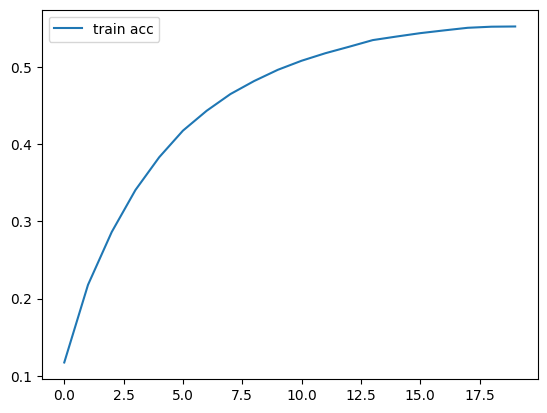

<Figure size 640x480 with 0 Axes>

In [16]:
plt.plot(history.history['accuracy'], label='train acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [17]:
def complete_this_song(seed_text, next_words):
    for _ in range(next_words):
        # Tokenize the seed text
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        
        # Predict the next word probabilities
        predicted_probs = model.predict(token_list, verbose=0)
        
        # Get the index of the word with the highest probability
        predicted_index = np.argmax(predicted_probs)
        
        # Get the predicted word
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted_index:
                output_word = word
                break
        
        # Update seed text for the next iteration
        seed_text += " " + output_word
    
    return seed_text

In [18]:
complete_this_song("sunrise on a mountain", 30)

'sunrise on a mountain on a park in the middle of the night in the rain i m in the room i m out of the room i m out of the time i'

In [19]:
from tensorflow.keras.models import load_model
model.save('model2.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [20]:
model = load_model('/kaggle/working/model2.h5')